## Computer Vision Base Trainer

The basic steps we'll take are:

1. Importing our collected, organized, and cleaned images
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture from our test dataset and see if it works.

## STOP HERE, THIS IS THE BASE TRAINER, MAKE A COPY AND DO YOUR WORK THERE

Describe what you want to do for this trainin here:

Augmentation Transforms: 

Pre-Trained Model: 

Batch Size: 

Validation Size: 

Epochs: 


## STEP 0: Ensure you are running this notebook within a Docker Container

View the README.md file for instructions on building and running a container.

## STEP 1: Import the image data to the workspace so we can use them to train a model

The Docker container will create a nice `workspace` for us that we can recreate if we ever need to start over from scratch. This can allow us to try many different things from the same starting point if we want.

The folder structure for this workspace is
 - data (our collected data will be placed here)
 - images (other images we may need that is not the data)
 - models (models we choose to save will be stored here)
 - notebooks (the notebooks we run can be found in this directory)

Within our code, we can use both **absolute** and **relative** paths. This notebook is inside of the notebooks folder, and to reference a file in the data folder we can use the following options below:
 - absolute path: `/workspace/data/filename.zip`
 - relative path: `../data/filename.zip` (the `..` in this case means from where this file is, go up one folder)

The code below imports `zipfile` and `os` so that we can work with the filesystem. Take a close look at the comments for each line as explanations for what will happen when we run the code in that cell.

In [1]:
import zipfile
import os

# Define the path to the zip file and the extraction directory
zip_file_name = 'MuseumImages_Resized' # You will want to change this filename to the filename of your data

zip_file_path = f"/workspace/data/{zip_file_name}.zip" # You should not need to edit anything here because the zip_file_path references the variable containing the filename above, this code assumes it will be a zip file
extract_to_dir = '/workspace/data/' # This is where the extracted zip file will go, turning that one zip file into the directories and images files that we will need to work with for training

# Check if the TRAINING_DATA directory already exists
if not os.path.exists(extract_to_dir+zip_file_name): # If the directory with the real data doesn't exist, run the code inside this if statement. 
    # Create the extraction directory if it doesn't exist
    os.makedirs(extract_to_dir, exist_ok=True) # Since the directory does not exist, it needs to be created

    # Open the zip file and extract its contents
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref: # These two lines extract the data from the zip file, and place them in the defined path for the extract_to_dir variable
        zip_ref.extractall(extract_to_dir)

    print(f"Extracted all files to {extract_to_dir}") # Recall that print statments can be very useful, this print statement let's you know that the extraction process has completed
else: # This else block will only run if the directory with the real data already exists. If you need to unzip the data again, you will have to remove this directory inside the /workspace/data/ directory
    print(f"Directory {extract_to_dir} already exists. Skipping extraction.") # Since this block only runs if the directory already exists, it's helpful to get a message that it's already there


Extracted all files to /workspace/data/


Depending on the size of your zip file, and the amount of data you are importing, this may take a while. But once you have extracted the data, the Docker container is setup so that it will persist (stay around) when you come back to this notebook again.

*NOTE: You do not want to run this cell until the zip file has been fully uploaded to the `/workspace/data/` directory. If you see an error that the zip file is not a zip file, but you know that it is, it has not finished uploading yet.*

## Step 2: Train an initial model so that we clean our data

The goal of step 2 is to do a light run of the training in order to clean up our data. While it may seem to make the most sense to clean the data by looking at every picture before we even attempt to train (and you should definitely give your data a look through), cleaning after running a few epochs of fine tuning can be very helpful.

We will be using the FastAPI library from Fast.AI to train our models. Documentation for this library can be found at [https://docs.fast.ai/](https://docs.fast.ai/).

For our purposes, we will be working within the subset of the API for **Computer Vision**.
 - This means we do not need to import all of fast ai (`import fastai`).
 - Instead, we will just need to import the subset of the api for `vision` (`from fastai.vision.all import *`)
   - note that the `*` here means everything within `fastai.vision.all`

In [2]:
from fastai.vision.all import *

Now that we have access to the tools we will need for training, it can be helpful to set a variable for the `path` to where the data is stored. I often put mine in a directory called *TRAINING_DATA*, but yours should be the same as the name extracted from the zip file you unpacked above

For example, if my zipfile was named `IAN_DATA.zip` and created a folder called `IAN_DATA` I would modify the assignment of `path` to be `path = /workspace/data/IAN_DATA`. The `.zip` is dropped here because we are looking at the folder that was created through the unzipping process, and not the compressed file.

In [5]:
path = '/workspace/data/MuseumImages_Resized'

Now that the location of the data is set in a variable, we *might* want to verify that all of our data is image data. If you have collected and organized all of the data, and are confident you don't have any random files in the directories, you may not need this. But, it can be helpful to run it once to ensure we won't have filetype issues going forward.

In [ ]:
# only run this test if you've added new data to the training data
# it does NOT need to be run if you're confident that the image files are valid 
failed = verify_images(get_image_files(path)) # this looks at all of the files in our defined path and verifies that they are images, and failures will be placed in the failed variable
failed.map(Path.unlink) # if there are any failes that were not images, remove them from the data
len(failed) # show the number of failed files, ideally this will be 0, but even if it's more than 0 know that those files are now gone and we don't need to worry about them

To train a model, we'll need a `DataLoader`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')],
    batch_tfms=[
        *aug_transforms(size=192, min_scale=0.75, p_lighting=0.8, do_flip=true),  # Adjust the p_lighting parameter
        Normalize.from_stats(*imagenet_stats)
    ]
).dataloaders(path, bs=256)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest"). Meaning we can send it a picture and it will give us some text.

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be the names of each plant).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

    batch_tfms=[
        *aug_transforms(size=192, min_scale=0.75, p_lighting=0.8, do_flip=true),
        Normalize.from_stats(*imagenet_stats)
    ]

For each batch, which is 256 at a time for this code, set the probability of changing the lighting (p_lighting) of the image to 75% and use random flipping (do_flip=true) for each set of data

Read more about data augmentations, whether at the item level, or batch level, at [https://docs.fast.ai/vision.augment.html](https://docs.fast.ai/vision.augment.html) (you will want to scroll to the bottom to see a list of these parameters)

The code above let's us take a look at how a batch (256 in the code above, `bs=256`) of the data is augmented based on the parameters of the dataloader. 
You should see images that have been:
 - squished into 192 x 192 pixel sized squares (`size=192`)
 - some cropping (`min-scale=0.75`)
 - a change in the brightness or contrast (`p_lighting=0.8`)
 - some random flipping (`do_flip=true`)

These augmentations allow our data to become more than just what the image originally was. Our model doesn't need to require that the original image was taken upside-down sometimes, but can account for that possibility through the data augmentation.

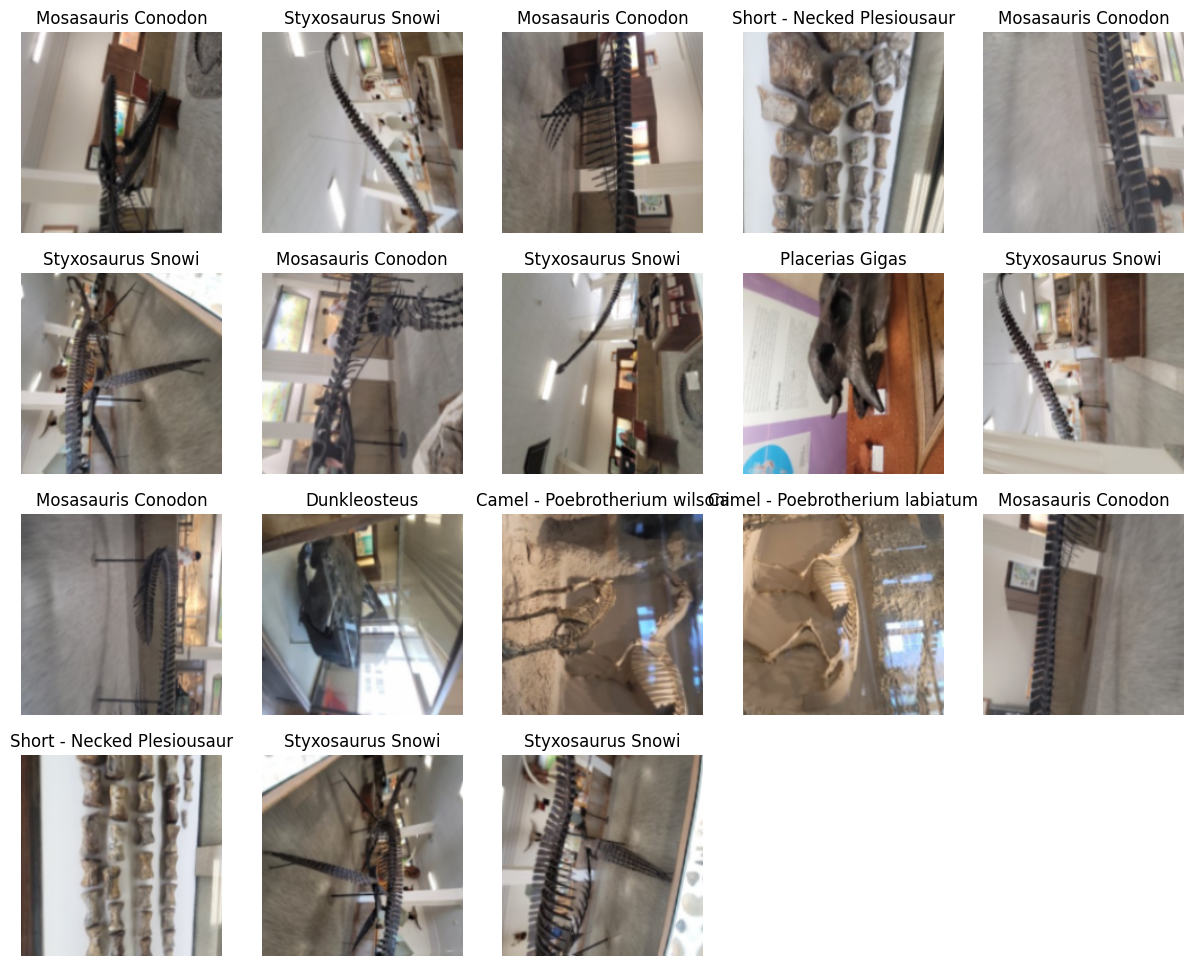

In [10]:
dls.show_batch(max_n=18)

Now we're ready to train our model. A fast, and widely used computer vision model is `resnet18`, which is a pre-trained model that already works for other images. The `resnet18` model was trained on the ImageNet dataset, which is comprised of significantly more images and categories than we are likely to use in this trainer notebook. It is a *pre-trained* model that we can build upon, instead of needing to develop a model from scratch. The `18` referes to the number of layers in the model. Other options are `resnet34`, `resnet50`, `resnet101`, and `resnet152`. To use any of these other pre-trained models, you simply replace `resnet18` with the one you prefer below in the `vision_learner()` parameters. 
Example: `learn = vision_learner(dls, resnet101, metrics=error_rate)`

More information about pretrained models, and others that you may want to use instead of `resnet18` can be found at [https://www.kaggle.com/code/jhoward/which-image-models-are-best](https://www.kaggle.com/code/jhoward/which-image-models-are-best).

**The code below creates a learner, and in this case a vision_learner since we are working within *computer vision.***

More information about learners in can be found at [https://docs.fast.ai/learner.html](https://docs.fast.ai/learner.html).

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate) # create the learner

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:01<00:00, 32.0MB/s]


Once we have a learner, we will want to find an optimal learning rate, which can be thought of as the step size to take during the learning (fine tuning). Too small of a learning rate, and it might take a long time to find the best model for our data. Too large of a learning rate and we might jump right over the best model for our data.

We will use the value that the code below (`learn.lr_find`) returns when we fine tune the model for our dataset.

More information about the learning rate can be found at [https://medium.com/@bijil.subhash/transfer-learning-how-to-pick-the-optimal-learning-rate-c8621b89c036](https://medium.com/@bijil.subhash/transfer-learning-how-to-pick-the-optimal-learning-rate-c8621b89c036).

SuggestedLRs(valley=0.0008317637839354575)

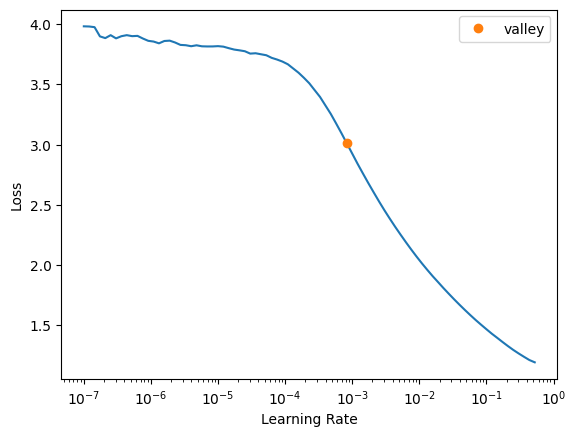

In [12]:
learn.lr_find() # find the learning rate

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

**Recall that in this *step* we are training in order to clean the data. 3 epochs should be adequate for this, and it is suggested you don't try to train here as if this is the final step.**

In [16]:
learning_rate = 0.0008317637839354575 # use the value from the lr_find() method above

In [17]:
initial_training_epochs = 3
learn.fine_tune(initial_training_epochs, base_lr=learning_rate) 

epoch,train_loss,valid_loss,error_rate,time
0,0.040993,0.014343,0.006772,00:35


epoch,train_loss,valid_loss,error_rate,time
0,0.026335,0.012930,0.006772,00:32
1,0.021589,0.011704,0.004515,00:37
2,0.016397,0.010777,0.004515,00:38


Now that our initial pass has completed, let's look at the results.

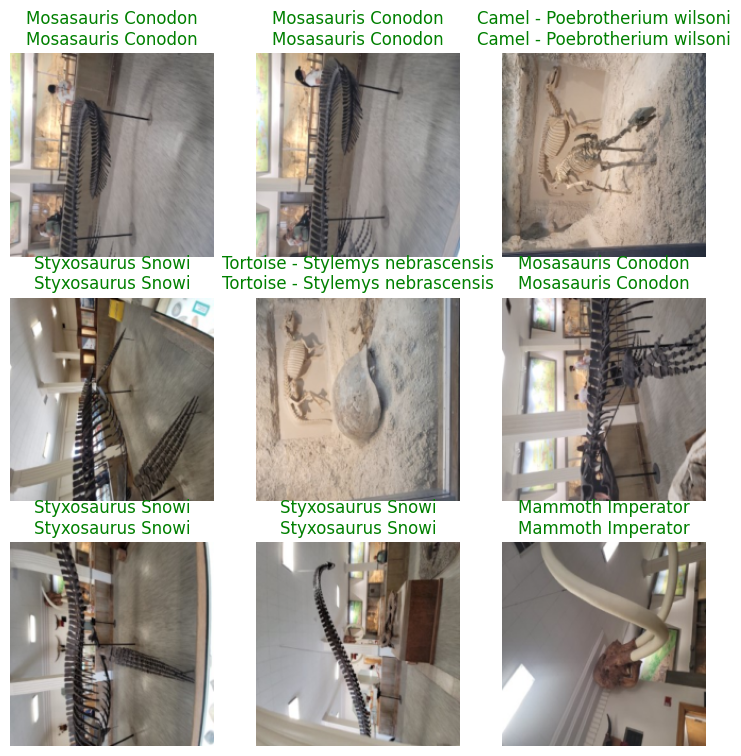

In [15]:
learn.show_results()

## Step 3: Let's see how our model did and what it had the most difficulty with

To interpret the predictions for our model we will use an interpretation function. Since we are specifically interested in classification for this model (giving it a piece of data and receiving a category label), we will use the `ClassificationInterpretation` class and tell it to interpret from the learner we've been using so far.

Documentation can be found at [https://docs.fast.ai/interpret.html](https://docs.fast.ai/interpret.html).

In [18]:
interp = ClassificationInterpretation.from_learner(learn)

Now that we have our interpretation, let's examine a confusion matrix for the model. Running the cell below will show the percentage of categories that were either correctly, or incorrectly, identified. If you would prefer to see the raw numbers of elements, modify the `normalize` parameter to `False`.

You can read more about the what a confusion matrix shows at [https://www.geeksforgeeks.org/confusion-matrix-machine-learning/](https://www.geeksforgeeks.org/confusion-matrix-machine-learning/)

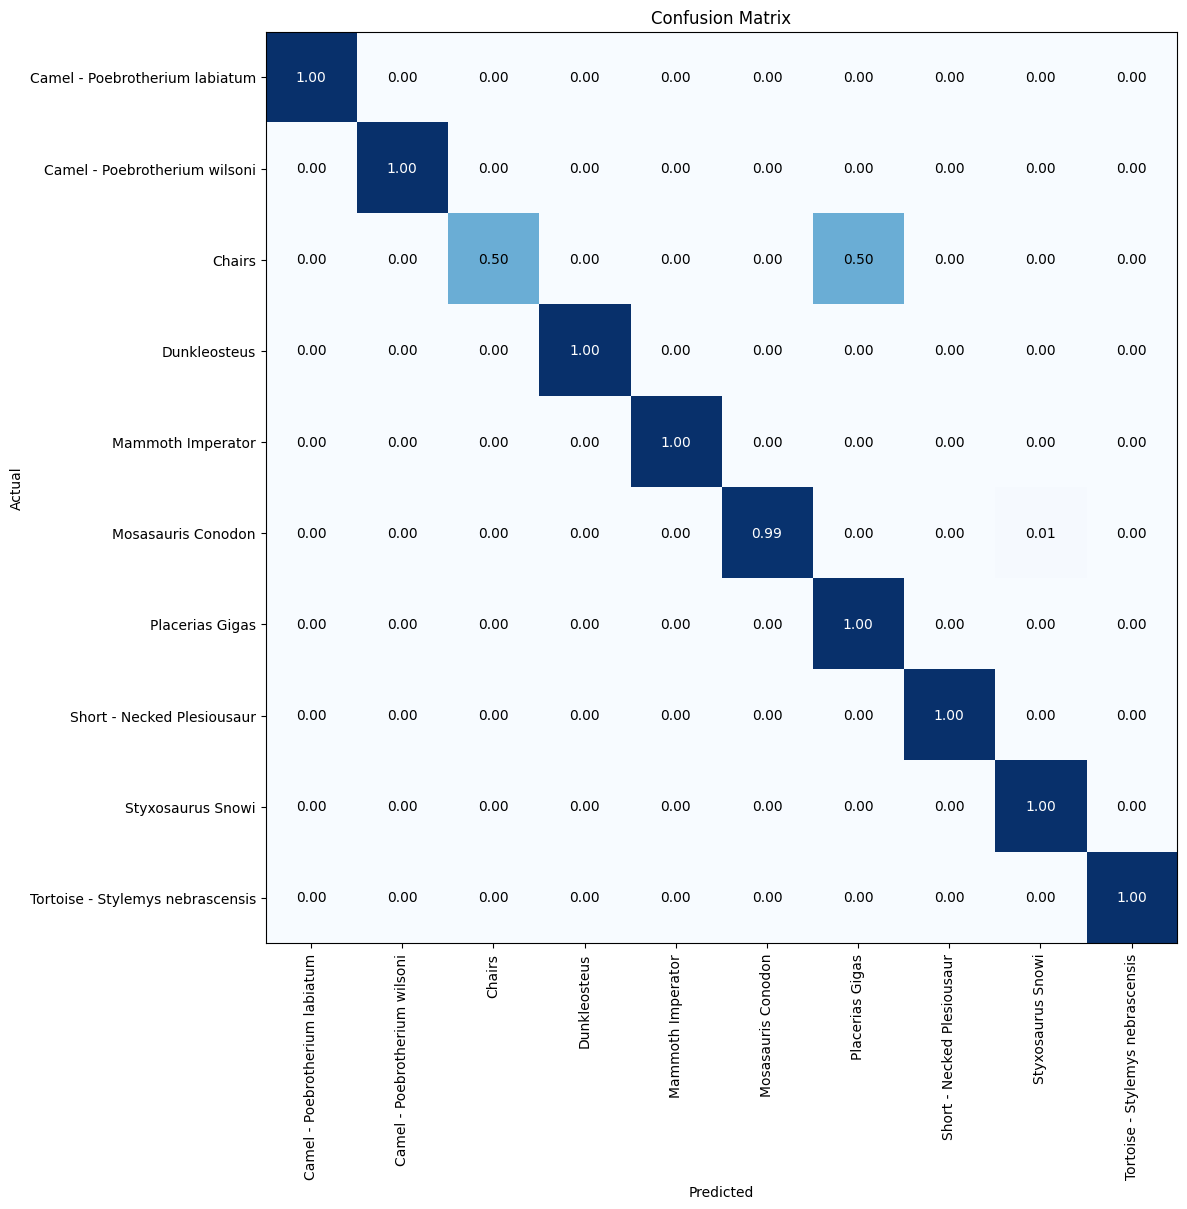

In [19]:
interp.plot_confusion_matrix(normalize=True, title='Confusion Matrix', figsize=(12, 12))

We can also use our interpretation to show items in our dataset that the model had the most trouble with. The `plot_top_losses` method below may show high confidence (probability) that an image is one category (prediction), but it was actually (actual) organized in the data as another. We will be able to clean up any mislabeled data in Step 5.

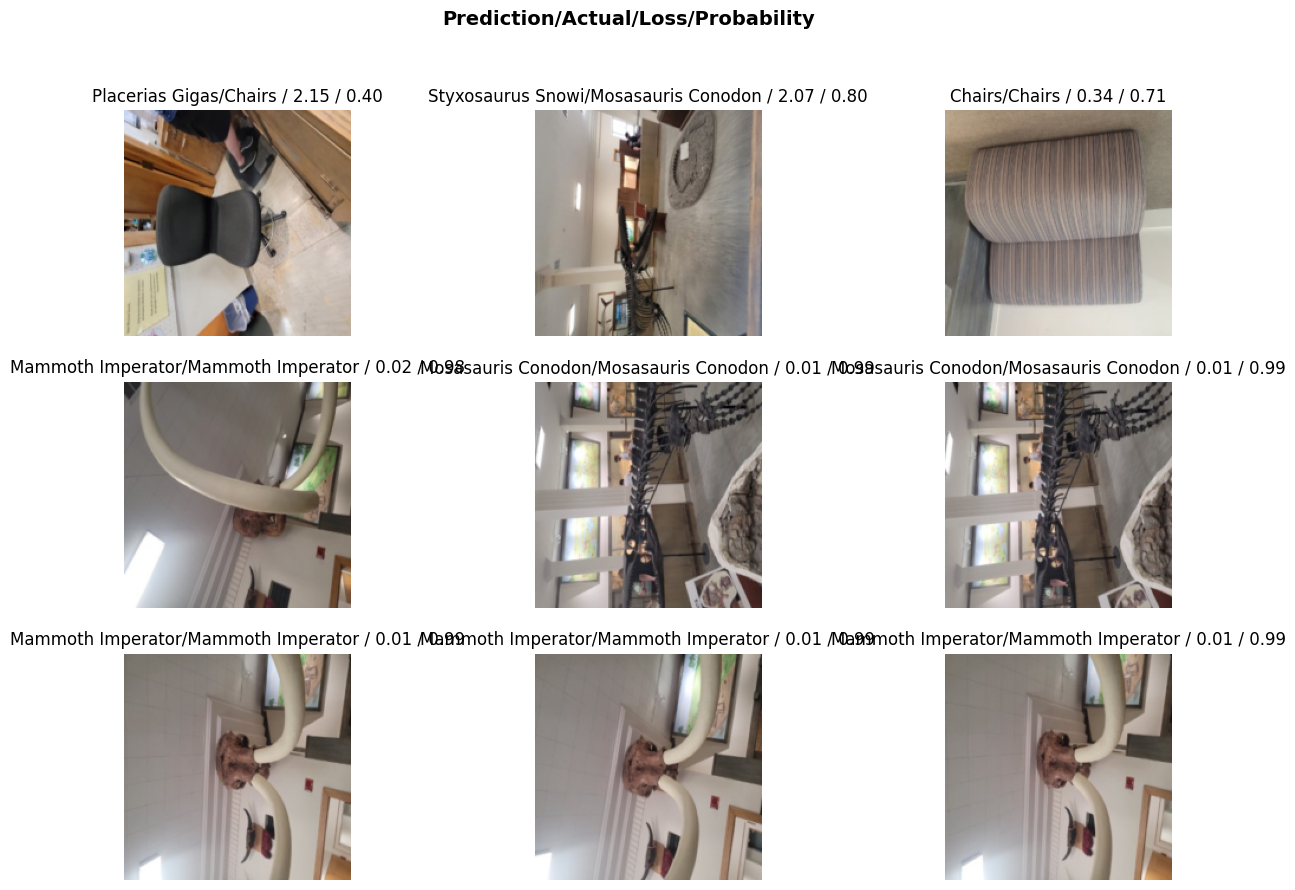

In [20]:
interp.plot_top_losses(9, figsize=(15,10))

And finally, if you want to test out individual files you can use the code below. I suggest creating a new folder called `TEST_IMAGES` in `/workspace/images/` and uploading some files to test there. This should result in an image with the filename `yarrow.jpg` having a full path of `/workspace/images/TEST_IMAGES/yarrow.jpg`.

The code below will use that path, show you a thumbnail of the image, and then use `learn.predict()` to return an identified category.

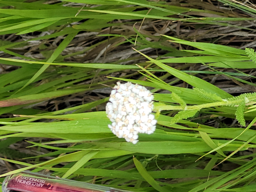

In [21]:
img_file = 'yarrow.jpg'
img_path = f"/workspace/images/TEST_IMAGES/{img_file}"
Image.open(img_path).to_thumb(256,256)

In [22]:
category,_,probs = learn.predict(PILImage.create(img_path))
print(f"This is a: {category}.")

This is a: Chairs.


## Step 4: Let's clean the data

At this stage, we may have identified some bad or mislabeled data. We will use the `ImageClassifierCleaner` function on our learner to let us modify any labels, or potentially remove data, directly from this notebook.

You may find that large collections of data may have been mislabeled, which may result in actually modifying the data found in `/workspace/data/`. You should feel free to do this, but you will likely want to run steps 2-3 again on this modified data. Situations like this can occur if multiple sets of data are being put into one large collection of data and end up in the wrong folder.

When using the cleaner below, you should know that what you see is organized in order of lowest probability to highest. So the first images are the most likely to be challenging for our model. Using the drop-down tool under each image, you can choose to **keep** that image with that category, **delete** it, or **move it to a new category**. You will want to examine every category, for both the training, and the validation, sets of data. 

A quick reminder that these were created using the `splitter` parameter in the `DataBlock` earlier. If you have left that code as is, this resulted in 20% of the data being used for the validation set, and 80% being used for training (`splitter=RandomSplitter(valid_pct=0.2, seed=42)`).

In [26]:
from fastai.vision.widgets import ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learn)
cleaner

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 3.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/_utils/fetch.py", line 41, in fetch
    data = next(self.dataset_iter)
  File "/usr/local/lib/python3.8/dist-packages/fastai/data/load.py", line 138, in create_batches
    yield from map(self.do_batch, self.chunkify(res))
  File "/usr/local/lib/python3.8/dist-packages/fastcore/basics.py", line 234, in chunked
    res = list(itertools.islice(it, chunk_sz))
  File "/usr/local/lib/python3.8/dist-packages/fastai/data/load.py", line 168, in do_item
    try: return self.after_item(self.create_item(s))
  File "/usr/local/lib/python3.8/dist-packages/fastai/data/load.py", line 175, in create_item
    if self.indexed: return self.dataset[s or 0]
  File "/usr/local/lib/python3.8/dist-packages/fastai/data/core.py", line 447, in __getitem__
    res = tuple([tl[it] for tl in self.tls])
  File "/usr/local/lib/python3.8/dist-packages/fastai/data/core.py", line 447, in <listcomp>
    res = tuple([tl[it] for tl in self.tls])
  File "/usr/local/lib/python3.8/dist-packages/fastai/data/core.py", line 406, in __getitem__
    return self._after_item(res) if is_indexer(idx) else res.map(self._after_item)
  File "/usr/local/lib/python3.8/dist-packages/fastai/data/core.py", line 366, in _after_item
    def _after_item(self, o): return self.tfms(o)
  File "/usr/local/lib/python3.8/dist-packages/fastcore/transform.py", line 208, in __call__
    def __call__(self, o): return compose_tfms(o, tfms=self.fs, split_idx=self.split_idx)
  File "/usr/local/lib/python3.8/dist-packages/fastcore/transform.py", line 158, in compose_tfms
    x = f(x, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/fastcore/transform.py", line 81, in __call__
    def __call__(self, x, **kwargs): return self._call('encodes', x, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/fastcore/transform.py", line 91, in _call
    return self._do_call(getattr(self, fn), x, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/fastcore/transform.py", line 97, in _do_call
    return retain_type(f(x, **kwargs), x, ret)
  File "/usr/local/lib/python3.8/dist-packages/fastcore/dispatch.py", line 120, in __call__
    return f(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/fastai/vision/core.py", line 125, in create
    return cls(load_image(fn, **merge(cls._open_args, kwargs)))
  File "/usr/local/lib/python3.8/dist-packages/fastai/vision/core.py", line 98, in load_image
    im = Image.open(fn)
  File "/usr/local/lib/python3.8/dist-packages/PIL/Image.py", line 3431, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '/workspace/data/MuseumImages_Resized/Tortoise - Stylemys nebrascensis/20240514_074656.jpg'


Once you have cleaned the data, the code below will use a `for` loop to enact any of the modifications you made on the data.

In [24]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Finally, if you are satisfied with your trained `Learner`, then you can export the file that contains all the information needed to use the model elsewhere, whether that be in an application or for futue training.

In [25]:
learn.export('../models/model.pkl')

## Step 5: Now We Train A Model Using What We've Learned

Here's what we have at this point:
 - A data learner that can run effectively using our chosen parameters
 - The batch size that let's us optimally utilize the resources on our computer
 - The learning rate that is effective for the data_learner and data
 - A cleaned up dataset to work with for training

We now know a lot about or data and model, likely enough to run a train for many epochs. Use the variables below to setup your script to:
 1. set how many epochs should be run in between saves
 1. provide the path to a previously saved model if you want to start from there

*Note 1: load_learner requires all your custom code be in the exact same place as when exporting your Learner (the main script, or the module you imported it from). So don't modify this script after you've exported the model.*

*Note 2: models may not be small, you will want to account for the amount of space you have on your computer and how many saves you may trigger while training. If your model is 50MB, and you will save 10 times, that turns into 500MB of models stored on your computer.*

*Note 3: Notice that the learning rate is not defined here. It has already been set earlier, and we do not need to recreate it.*

Here is an explanation about what is happening in the code below.

Custom Callback:
 - `SaveModelCallback` is a custom callback that saves the model every `self.every` epochs, appending the epoch number to the file name.

Jupyter Notebook:
 - Load the model and data loaders as before.
  - You will either continue running from a .pth file, or .pkl file. The default is from a .pkl file and is set using `recover_from_pth_file`
 - Instantiate the `SaveModelCallback` and pass it to `learn.fine_tune` using the `cbs` parameter.
 - Save the final model at the end.

**Good luck with your model training**

In [19]:
#first set how often the model should save a checkpoint file, these will be stored as .pth files, not .pkl
# not that .pth files will contain the model architecture, whereas .pkl files do not, which means .pth files are much larger in size
save_after_this_many_epochs = 2

In [20]:
from fastai.callback.core import Callback

class SaveModelCallback(Callback):
    def __init__(self, every=10, path='model', last_epoch_save=3):
        self.every = every
        self.path = path
        self.last_epoch_save = last_epoch_save

    def after_epoch(self):
        "Save the model every `self.every` epochs"
        if (self.epoch + 1) % self.every == 0:
            self.learn.save(f'{self.path}_epoch{self.epoch + (1+self.last_epoch_save)}')


In [21]:
from fastai.learner import load_learner
from fastai.data.core import DataLoaders

# Define your data loading function
def get_dls(path_to_data):
    # Your data loading logic here, it needs to match what you used for the model
    # For example, this could be something like:
    # dls = ImageDataLoaders.from_folder(path, train='train', valid='valid', ...)
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock), 
        get_items=get_image_files, 
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label,
        item_tfms=[Resize(192, method='squish')],
        batch_tfms=[
            *aug_transforms(size=192, min_scale=0.75, p_lighting=0.8, do_flip=true),  # Adjust the p_lighting parameter
            Normalize.from_stats(*imagenet_stats)
        ]
    ).dataloaders(path_to_data, bs=256)

# Define your data recover function, this function will return .pkl model from one of your checkpoint save files in the .pth format
# path = the path to your data (e.g. /workspace/data/TRAINING_DATA), path_to_pth_model = the path to your last saved .pth file
def recover_dl_from_pth(path, path_to_pth_model):
    dls = ImageDataLoaders.from_folder(path)
    learn = cnn_learner(dls, resnet18) # be sure to use the same pretrained model here that you did for previous training
    learn.load(path_to_pth_model)  # Load the model from the .pth file
    return learn


# Load the previously trained model
last_epoch_save = 3
recover_from_pth_file = False

if(recover_from_pth_file):
    # The code below will create a learner recovered from a checkpoint save
    # You will want to make sure that the pretrained model in recover_dl_from_pth() the same as what was used for fine tuning earlier
    learn_long = recover_dl_from_pth(path, '/workspace/models/model_epochEPOCH_NUM_HERE_TO_GET_TO_CORRECT_FLE.pth')
else:
    # This code will recover from a .pkl file
    previous_model_path = '/workspace/models/model10.pkl'  # replace with your actual model path
    learn_long = load_learner(previous_model_path) #note that this is creating a different learner than the one we used above
    # Ensure data loaders are set up
    learn_long.dls = get_dls(path) # path is the path to our data, which was set earlier

# Instantiate the custom callback
# modify last_epoch_save to be the number of epochs the model was trained up to
save_model_callback = SaveModelCallback(every=save_after_this_many_epochs, path='/workspace/models/model', last_epoch_save = last_epoch_save)

# Define the number of additional epochs you want to train for
additional_epochs = 7  # Set the total number of epochs

# Continue training the model with the custom callback
learn_long.fine_tune(additional_epochs, base_lr=learning_rate, cbs=[save_model_callback])

# Save the updated model at the end
updated_model_path = f'/workspace/models/model_epoch{(last_epoch_save+additional_epochs)}.pkl'
learn_long.export(updated_model_path)

print("Training completed and model saved.")


epoch,train_loss,valid_loss,error_rate,time
0,0.080513,0.086606,0.028842,14:27


epoch,train_loss,valid_loss,error_rate,time
0,0.064099,0.060639,0.020294,13:38
1,0.053941,0.068405,0.023111,13:27
2,0.040976,0.041189,0.012941,12:01
3,0.024358,0.031453,0.010075,13:18
4,0.015188,0.026384,0.008977,13:20
5,0.011379,0.019536,0.007401,13:14
6,0.011717,0.021512,0.007927,13:10


Training completed and model saved.


After all of that training, you may want to take another look at the confusion matrix. How does it compare to your initial model?

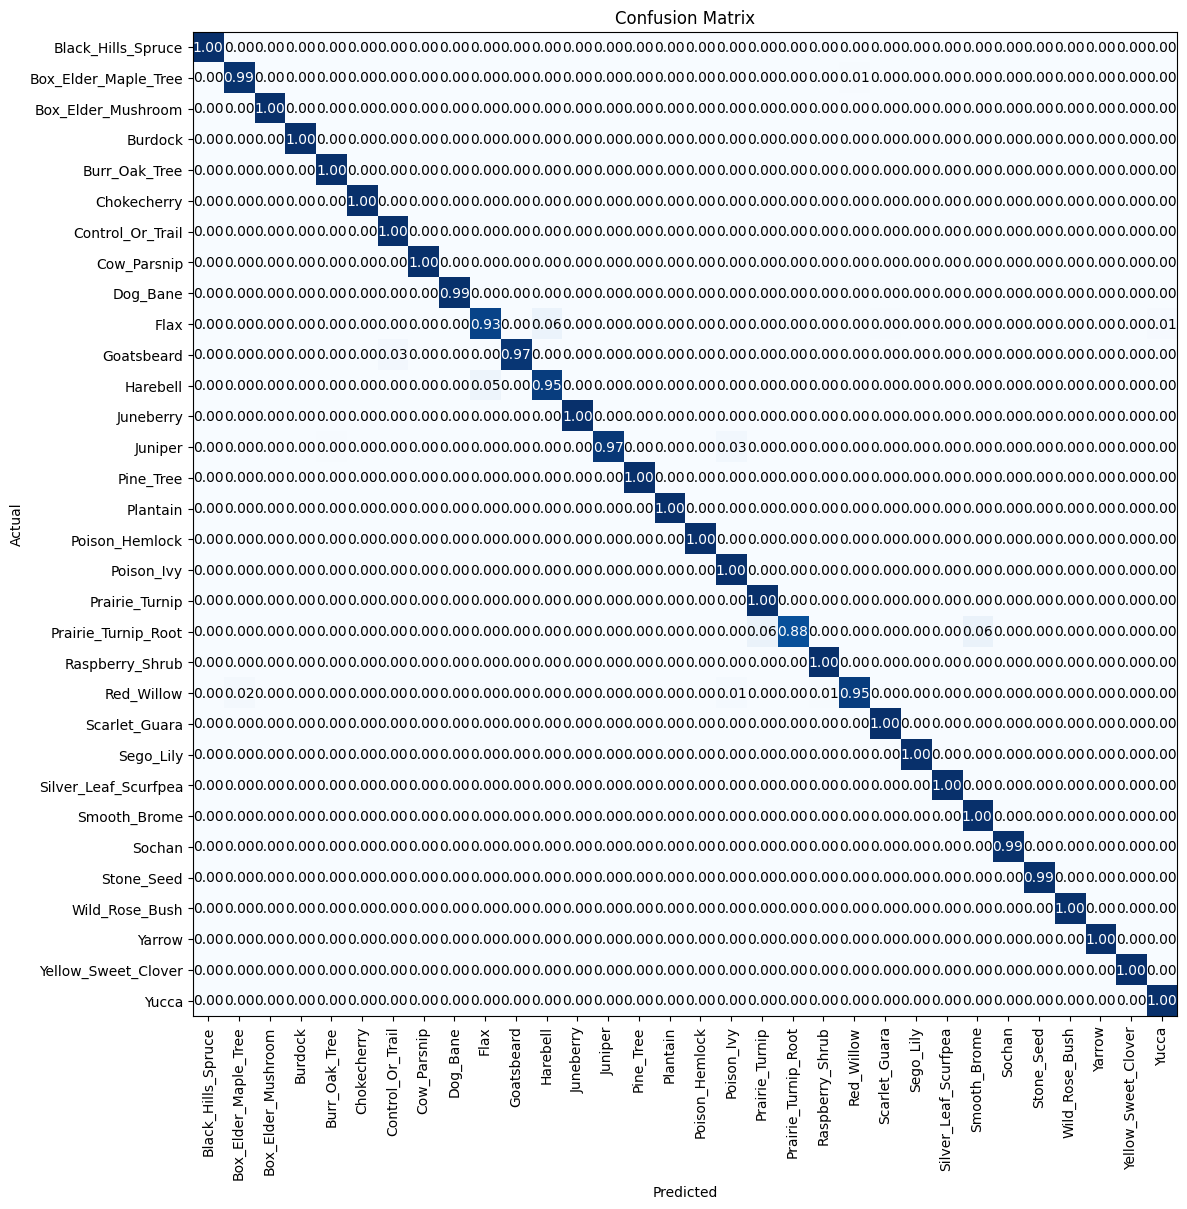

In [22]:
interp_long = ClassificationInterpretation.from_learner(learn_long)
interp_long.plot_confusion_matrix(normalize=True, title='Confusion Matrix', figsize=(12, 12))